Matplotlib is building the font cache; this may take a moment.


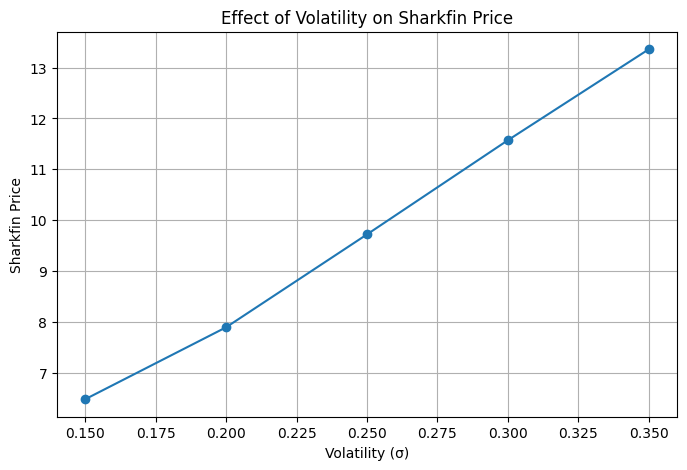

[(0.15, np.float64(6.47530322771878)),
 (0.2, np.float64(7.890562531419168)),
 (0.25, np.float64(9.718494758303564)),
 (0.3, np.float64(11.571670401163217)),
 (0.35, np.float64(13.361336189838122))]

In [1]:
# Re-run the volatility analysis after execution state reset

import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_simulations = 100000  # Number of Monte Carlo paths
T = 2  # Time to maturity in years
dt = 1 / 252  # Daily time step (assuming 252 trading days in a year)
n_steps = int(T / dt)  # Total steps in simulation

# Product parameters
S0 = 100  # Initial stock price
strike = 100  # Strike price (same as initial price)
KO_level = 150  # Knock-Out at 150% of S0
KI_level = 70  # Knock-In at 70% of S0
participation = 0.60  # 60% exposure to stock upside
cap = 29.99 / 100  # 29.99% max return
KO_return = 5.1 / 100  # Fixed return if KO is hit
loss_factor = 0.80  # 80% loss sharing if KI is breached

# Market parameters
r = 0.04  # Risk-free rate (4% annual)

# Define different volatility levels to test
volatility_levels = [0.15, 0.20, 0.25, 0.30, 0.35]  # 15% to 35%
sharkfin_prices = []

for sigma in volatility_levels:
    # Simulate stock price paths using Geometric Brownian Motion (GBM)
    np.random.seed(42)  # For reproducibility
    Z = np.random.randn(n_simulations, n_steps)  # Standard normal variates
    S = np.zeros((n_simulations, n_steps))  # Stock price paths
    S[:, 0] = S0  # Initial stock price

    # Generate price paths
    for t in range(1, n_steps):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Final stock prices
    S_T = S[:, -1]

    # Knock-Out check: Any path that hit KO at any point gets 5.1% return
    KO_hit = (S >= KO_level).any(axis=1)
    payout_KO = KO_hit * (KO_return * S0)

    # Knock-In check: Any path that fell below KI at any point shares in losses
    KI_hit = (S <= KI_level).any(axis=1)

    # Standard Sharkfin payoff
    payout = participation * (S_T - S0)  # 60% of the stock's gain
    payout = np.minimum(payout, cap * S0)  # Apply cap
    payout = np.maximum(payout, 0)  # No negative payouts

    # Apply KI Loss Factor if breached
    payout_KI = KI_hit * (-loss_factor * (S_T - S0))
    payout_KI[~KI_hit] = 0  # If KI was not hit, no loss applied

    # Final payout (taking KO & KI into account)
    final_payout = np.where(KO_hit, payout_KO, payout + payout_KI)

    # Discount to present value
    discounted_payout = np.exp(-r * T) * final_payout
    sharkfin_price = np.mean(discounted_payout)
    
    # Store the result
    sharkfin_prices.append(sharkfin_price)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(volatility_levels, sharkfin_prices, marker='o', linestyle='-')
plt.xlabel("Volatility (σ)")
plt.ylabel("Sharkfin Price")
plt.title("Effect of Volatility on Sharkfin Price")
plt.grid(True)
plt.show()

# Return calculated values for reference
list(zip(volatility_levels, sharkfin_prices))
